# Exercise 3
## Spam Classification
### Context
The SMS Spam Collection is a set of SMS tagged messages that have been collected for SMS Spam research. It contains one set of SMS messages in English of 5,574 messages, tagged acording being ham (legitimate) or spam.

### Content
The files contain one message per line. Each line is composed by two columns: v1 contains the label (ham or spam) and v2 contains the raw text.

This corpus has been collected from free or free for research sources at the Internet:

- A collection of 425 SMS spam messages was manually extracted from the Grumbletext Web site. This is a UK forum in which cell phone users make public claims about SMS spam messages, most of them without reporting the very spam message received. The identification of the text of spam messages in the claims is a very hard and time-consuming task, and it involved carefully scanning hundreds of web pages. The Grumbletext Web site is: [Web Link](http://www.grumbletext.co.uk/).
- A subset of 3,375 SMS randomly chosen ham messages of the NUS SMS Corpus (NSC), which is a dataset of about 10,000 legitimate messages collected for research at the Department of Computer Science at the National University of Singapore. The messages largely originate from Singaporeans and mostly from students attending the University. These messages were collected from volunteers who were made aware that their contributions were going to be made publicly available. The NUS SMS Corpus is avalaible at: [Web Link](http://www.comp.nus.edu.sg/~rpnlpir/downloads/corpora/smsCorpus/).
- A list of 450 SMS ham messages collected from Caroline Tag's PhD Thesis available at [Web Link](http://etheses.bham.ac.uk/253/1/Tagg09PhD.pdf).
- Finally, we have incorporated the SMS Spam Corpus v.0.1 Big. It has 1,002 SMS ham messages and 322 spam messages and it is public available at: [Web Link](http://www.esp.uem.es/jmgomez/smsspamcorpus/). This corpus has been used in the following academic researches:

Acknowledgements
The original dataset can be found [here](https://archive.ics.uci.edu/ml/datasets/SMS+Spam+Collection). The creators would like to note that in case you find the dataset useful, please make a reference to previous paper and the web page: http://www.dt.fee.unicamp.br/~tiago/smsspamcollection/ in your papers, research, etc.

We offer a comprehensive study of this corpus in the following paper. This work presents a number of statistics, studies and baseline results for several machine learning methods.

Almeida, T.A., GÃ³mez Hidalgo, J.M., Yamakami, A. Contributions to the Study of SMS Spam Filtering: New Collection and Results. Proceedings of the 2011 ACM Symposium on Document Engineering (DOCENG'11), Mountain View, CA, USA, 2011.

In [1]:
!pip install wget

  Preparing metadata (setup.py) ... done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9655 sha256=28d0c87637ee0b31041461b8b3adae9e5083aa4442462adc03c98ee98167dd7d
  Stored in directory: /root/.cache/pip/wheels/8b/f1/7f/5c94f0a7a505ca1c81cd1d9208ae2064675d97582078e6c769
Successfully built wget


In [2]:
import pandas as pd
import numpy as np
import wget
import os
from zipfile import ZipFile

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import nltk
import string

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, auc, roc_curve
from sklearn.feature_extraction.text import TfidfVectorizer

import gensim
from gensim.models import Word2Vec
import warnings
import matplotlib.pyplot as plt
import seaborn as sns


warnings.filterwarnings('ignore')
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [3]:
try :
    from google.colab import files
    !wget https://archive.ics.uci.edu/ml/machine-learning-databases/00228/smsspamcollection.zip
    !unzip smsspamcollection.zip
    df = pd.read_csv('SMSSpamCollection', sep='\t',  header=None, names=['target', 'text'])
except ModuleNotFoundError :
    url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00228/smsspamcollection.zip'
    path = os.getcwd()+'\Data'
    wget.download(url,path)
    temp=path+'\smsspamcollection.zip'
    file = ZipFile(temp)
    file.extractall(path)
    file.close()
    df = pd.read_csv(path + '\SMSSpamCollection', sep='\t',  header=None, names=['target', 'text'])

--2023-09-23 03:41:38--  https://archive.ics.uci.edu/ml/machine-learning-databases/00228/smsspamcollection.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified
Saving to: ‘smsspamcollection.zip’

smsspamcollection.z     [ <=>                ] 198.65K  1024KB/s    in 0.2s    

2023-09-23 03:41:38 (1024 KB/s) - ‘smsspamcollection.zip’ saved [203415]

Archive:  smsspamcollection.zip
  inflating: SMSSpamCollection       
  inflating: readme                  


In [4]:
df.head()

,target,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [ ]:
display(df.shape) #Number of rows (instances) and columns in the dataset
df["target"].value_counts()/df.shape[0] #Class distribution in the dataset

(5572, 3)

ham     0.865937
spam    0.134063
Name: target, dtype: float64

In [ ]:
X = df['text']
y = df['target'].map({'ham':0, 'spam':1})

In [ ]:
# split data into training and validation set
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = df['target'], test_size = 0.3, random_state = 18)

Preprocess the text data by removing stop words, converting all text to lowercase, and removing punctuation using NLTK package.


In [ ]:
stop_words = set(stopwords.words('english'))
def preprocess(text):
    text = text.lower()
    text = ''.join([word for word in text if word not in string.punctuation])
    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word not in stop_words]
    return ' '.join(tokens)

X_train = X_train.apply(preprocess)
X_test = X_test.apply(preprocess)

Train a Word2Vec model on the preprocessed training data using Gensim package.

In [ ]:
sentences = [sentence.split() for sentence in X_train]
model = Word2Vec(sentences, vector_size=100, window=5, negative=20, min_count=1, workers=4)

Convert the preprocessed text data to a vector representation using the Word2Vec model.

In [ ]:
def vectorize(sentence):
    words = sentence.split()
    words_vecs = [model.wv[word] for word in words if word in model.wv]
    if len(words_vecs) == 0:
        return np.zeros(100)
    words_vecs = np.array(words_vecs)
    return words_vecs.mean(axis=0)

X_train = np.array([vectorize(sentence) for sentence in X_train])
X_test = np.array([vectorize(sentence) for sentence in X_test])

Train a classification model such as logistic regression, random forests, or support vector machines using the vectorised training data and the sentiment labels.

In [ ]:
clf = LogisticRegression()
clf.fit(X_train, y_train)

LogisticRegression()

Evaluate the performance of the classification model on the testing set with the accuracy, precision, recall and F1 score.

In [ ]:
y_pred = clf.predict(X_test)
fpr, tpr, thresholds = roc_curve(y_test, y_pred)

print('Accuracy:', accuracy_score(y_test, y_pred))
print('AUC:', auc(fpr, tpr))

Accuracy: 0.8660287081339713
AUC: 0.5


# **Excercise 3.1**

Remove stopwords, then predict target using CountVectorizer.

use Random Forest classifier

## **IMPORTAR Y DESCOMPRIMIR ARCHIVO**

In [13]:
try :
    from google.colab import files
    !wget https://archive.ics.uci.edu/ml/machine-learning-databases/00228/smsspamcollection.zip
    !unzip smsspamcollection.zip
    df = pd.read_csv('SMSSpamCollection', sep='\t',  header=None, names=['target', 'text'])
except ModuleNotFoundError :
    url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00228/smsspamcollection.zip'
    path = os.getcwd()+'\Data'
    wget.download(url,path)
    temp=path+'\smsspamcollection.zip'
    file = ZipFile(temp)
    file.extractall(path)
    file.close()
    df = pd.read_csv(path + '\SMSSpamCollection', sep='\t',  header=None, names=['target', 'text'])

--2023-09-23 03:52:28--  https://archive.ics.uci.edu/ml/machine-learning-databases/00228/smsspamcollection.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified
Saving to: ‘smsspamcollection.zip.1’

smsspamcollection.z     [ <=>                ] 198.65K  1.00MB/s    in 0.2s    

2023-09-23 03:52:29 (1.00 MB/s) - ‘smsspamcollection.zip.1’ saved [203415]

Archive:  smsspamcollection.zip
replace SMSSpamCollection? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

## **VISUALIZACIÓN DEL DATAFRAME**

In [18]:
df.head()

,target,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [19]:
display(df.shape) #Number of rows (instances) and columns in the dataset
df["target"].value_counts()/df.shape[0] #Class distribution in the dataset

(5572, 2)

ham     0.865937
spam    0.134063
Name: target, dtype: float64

## **DECLARACIÓN DE VARIABLES**

In [20]:
X = df['text']
y = df['target'].map({'ham':0, 'spam':1})

## **PREPROCESAMINETO - SE ELIMINAN STOPWORDS Y SIGNOS DE PUNTUACIÓN**

In [21]:
stop_words = set(stopwords.words('english'))
def preprocess(text):
    text = text.lower()
    text = ''.join([word for word in text if word not in string.punctuation])
    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word not in stop_words]
    return ' '.join(tokens)

X_train = X_train.apply(preprocess)
X_test = X_test.apply(preprocess)

NameError: ignored

## **CONJUNTOS DE ENTRENAMIENTO Y PRUEBA**

In [22]:
X_train, X_test, y_train, y_test = train_test_split(df['text'], df['target'], test_size=0.3, random_state=15)

## **VECTORIZADOR**

In [23]:
vectorizer = CountVectorizer()

## **FIT Y AJUSTE DE CONJUNTOS DE ENTRENAMIENTO Y PRUEBA**

In [24]:
X_train_counts = vectorizer.fit_transform(X_train)

In [25]:
X_test_counts = vectorizer.transform(X_test)

## **RANDOM FOREST**

**DECLARACIÓN DEL CLASIFICADOR**

In [26]:
rf_classifier = RandomForestClassifier()


**PRUEBA EL CLASIFICADOR**

In [27]:
rf_classifier.fit(X_train_counts, y_train)

RandomForestClassifier()

## **PREDICCIONES DEL MODELO EN EL CONJUNTO DE PRUEBA**

In [28]:
y_pred = rf_classifier.predict(X_test_counts)

In [29]:
print(y_pred)

['ham' 'ham' 'ham' ... 'ham' 'ham' 'ham']


## **EVALUACIÓN FINAL DEL MODELO 3.1**

In [31]:
accuracy = accuracy_score(y_test, y_pred)
print(f'Exactitud del modelo: {accuracy}')

Exactitud del modelo: 0.97188995215311


#**Excercise 3.2**

Predict target using TdidfVectorizer.

use Random Forest classifier

## **IMPORTAR Y DESCOMPRIMIR ARCHIVO**

In [ ]:
try :
    from google.colab import files
    !wget https://archive.ics.uci.edu/ml/machine-learning-databases/00228/smsspamcollection.zip
    !unzip smsspamcollection.zip
    df = pd.read_csv('SMSSpamCollection', sep='\t',  header=None, names=['target', 'text'])
except ModuleNotFoundError :
    url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00228/smsspamcollection.zip'
    path = os.getcwd()+'\Data'
    wget.download(url,path)
    temp=path+'\smsspamcollection.zip'
    file = ZipFile(temp)
    file.extractall(path)
    file.close()
    df = pd.read_csv(path + '\SMSSpamCollection', sep='\t',  header=None, names=['target', 'text'])

--2023-09-22 14:08:36--  https://archive.ics.uci.edu/ml/machine-learning-databases/00228/smsspamcollection.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified
Saving to: ‘smsspamcollection.zip.4’

smsspamcollection.z     [ <=>                ] 198.65K  --.-KB/s    in 0.03s   

2023-09-22 14:08:36 (6.26 MB/s) - ‘smsspamcollection.zip.4’ saved [203415]

Archive:  smsspamcollection.zip
replace SMSSpamCollection? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

## **VISUALIZACIÓN DEL DATAFRAME**

In [37]:
df.head()

,target,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [38]:
display(df.shape) #Number of rows (instances) and columns in the dataset
df["target"].value_counts()/df.shape[0] #Class distribution in the dataset

(5572, 2)

ham     0.865937
spam    0.134063
Name: target, dtype: float64

## **DECLARACIÓN DE VARIABLES**

In [39]:
X = df['text']
y = df['target'].map({'ham':0, 'spam':1})

## **PREPROCESAMINETO - SE ELIMINAN STOPWORDS Y SIGNOS DE PUNTUACIÓN**

In [40]:
stop_words = set(stopwords.words('english'))
def preprocess(text):
    text = text.lower()
    text = ''.join([word for word in text if word not in string.punctuation])
    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word not in stop_words]
    return ' '.join(tokens)

X_train = X_train.apply(preprocess)
X_test = X_test.apply(preprocess)

## **CONJUNTOS DE ENTRENAMIENTO Y PRUEBA**

In [41]:
X_train, X_test, y_train, y_test = train_test_split(df['text'], df['target'], test_size=0.3, random_state=15)

## **VECTORIZADOR**

In [42]:
tfidf_vectorizer = TfidfVectorizer()

## **FIT Y AJUSTE DE CONJUNTOS DE ENTRENAMIENTO Y PRUEBA**

In [43]:
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)

In [44]:
X_test_tfidf = tfidf_vectorizer.transform(X_test)

## **RANDOM FOREST**

**DECLARACIÓN DEL CLASIFICADOR**

In [45]:
rf_classifier = RandomForestClassifier()


**PRUEBA EL CLASIFICADOR**

In [46]:
rf_classifier.fit(X_train_tfidf, y_train)

RandomForestClassifier()

## **PREDICCIONES DEL MODELO EN EL CONJUNTO DE PRUEBA**

In [47]:
y_pred = rf_classifier.predict(X_test_tfidf)

In [48]:
print(y_pred)

['ham' 'spam' 'ham' ... 'ham' 'ham' 'ham']


## **EVALUACIÓN FINAL DEL MODELO 3.2**

In [49]:
accuracy = accuracy_score(y_test, y_pred)
print(f'Exactitud del modelo: {accuracy}')

Exactitud del modelo: 0.9730861244019139


#**Excercise 3.3**

Predict target using CountVectorizer or TfideVectorizer.

choose any classification model and justify why

## **COUNTVECTORIZER**

In [34]:
from sklearn.metrics import roc_auc_score

y_prob = rf_classifier.predict_proba(X_test_counts)[:, 1]

auc = roc_auc_score(y_test.map({'ham': 0, 'spam': 1}), y_prob)
print(f'AUC Score: {auc}')


AUC Score: 0.9913273234017363


In [35]:
from sklearn.metrics import roc_auc_score

y_prob = rf_classifier.predict_proba(X_test_counts)[:, 1]

auc = roc_auc_score(y_test.map({'ham': 0, 'spam': 1}), y_prob)
print(f'AUC Score: {auc}')


AUC Score: 0.9913273234017363


## **TFIDFVECTORIZER**

In [50]:
from sklearn.metrics import roc_auc_score

y_prob = rf_classifier.predict_proba(X_test_tfidf)[:, 1]

auc = roc_auc_score(y_test.map({'ham': 0, 'spam': 1}), y_prob)
print(f'AUC Score: {auc}')

AUC Score: 0.9914999753354381


In [51]:
from sklearn.metrics import roc_auc_score

y_prob = rf_classifier.predict_proba(X_test_tfidf)[:, 1]

auc = roc_auc_score(y_test.map({'ham': 0, 'spam': 1}), y_prob)
print(f'AUC Score: {auc}')


AUC Score: 0.9914999753354381


Los resultados numéricos obtenidos para CountVectorizer y TfidfVectorizer son excepcionales, ambos con un AUC (Area Under the Receiver Operating Characteristic Curve) de aproximadamente 99.13% y 99.15%, respectivamente, cuando se expresan en porcentaje.

AUC con CountVectorizer: 99.13%
AUC con TfidfVectorizer: 99.15%
Este nivel de rendimiento es extremadamente alto y sugiere que el modelo de clasificación es altamente efectivo en la tarea de distinguir entre spam y no spam, independientemente del vectorizador utilizado. En términos simples, el modelo prácticamente no comete errores al clasificar.

En cuanto a la elección entre CountVectorizer y TfidfVectorizer, ambas opciones han demostrado ser muy efectivas en este contexto. CountVectorizer se basa en la frecuencia de palabras, mientras que TfidfVectorizer pondera las palabras en función de su importancia relativa. Dado que ambos logran resultados excepcionales, la elección entre ellos puede depender de factores adicionales, como la interpretación del modelo o los recursos computacionales disponibles.

En cuanto al modelo de clasificación, en este caso, cualquier modelo podría funcionar bien debido a la calidad del preprocesamiento de datos y la selección de características. Los modelos de Random Forest, Support Vector Machine (SVM), Naive Bayes u otros modelos de aprendizaje automático podrían ser igualmente efectivos.

En resumen, los resultados son excelentes y sugieren que el problema de clasificación de spam y no spam se ha abordado con éxito. La elección entre CountVectorizer y TfidfVectorizer depende de consideraciones adicionales, y se puede seleccionar un modelo de clasificación basado en las necesidades específicas del proyecto. En general, este es un ejemplo de un modelo de clasificación muy efectivo y bien ajustado.

## **COMENTARIOS A LOS RESULTADOS**

#**Excercise 3.4**

Increase and decrece the parameters values vector_size, window and negative then predict the target.

Plot the different values of the parameters with the performance of the model.

Use a Random Forest classifier and classification model of your choice and justify why.

In [5]:
# Tokenizar el texto en el DataFrame (asumiendo que el texto está en una columna llamada 'texto')
df['texto_tokenizado'] = df['text'].apply(lambda x: x.split())

# Convertir la columna "target" en binario (spam: 1, ham: 0)
df['target_binario'] = df['target'].apply(lambda x: 1 if x == "spam" else 0)  # Personaliza según tus etiquetas

# Definir una función para entrenar y evaluar modelos Word2Vec
def train_and_evaluate_w2v(vector_size, window, negative):
    model = gensim.models.Word2Vec(
        sentences=df['texto_tokenizado'],
        vector_size=vector_size,
        window=window,
        negative=negative,
        min_count=1,
        sg=0
    )

    # Preparar datos para clasificación (usando media de vectores de palabras)
    X = np.array([np.mean([model.wv[word] for word in sentence], axis=0) for sentence in df['texto_tokenizado']])
    y = df['target_binario']

    # Dividir datos en conjuntos de entrenamiento y prueba
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Entrenar un clasificador Random Forest
    rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
    rf_classifier.fit(X_train, y_train)

    # Evaluar el rendimiento del modelo
    y_pred = rf_classifier.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    return accuracy, f1

parameter variation: `vector_size`

In [6]:
vector_sizes = [50, 100, 200]

parameter variation: `window`

In [7]:
windows = [3, 5, 7]

parameter variation: `negative`

In [8]:
negatives = [5, 10, 15]

In [9]:
# Almacenar resultados en diccionarios
accuracy_results = {}
f1_results = {}

# Entrenar y evaluar modelos con diferentes valores de parámetros
for vector_size in vector_sizes:
    for window in windows:
        for negative in negatives:
            key = (vector_size, window, negative)
            accuracy, f1 = train_and_evaluate_w2v(vector_size, window, negative)
            accuracy_results[key] = accuracy
            f1_results[key] = f1

Running best parameters `vector_size, window and negative` (All at the same time)

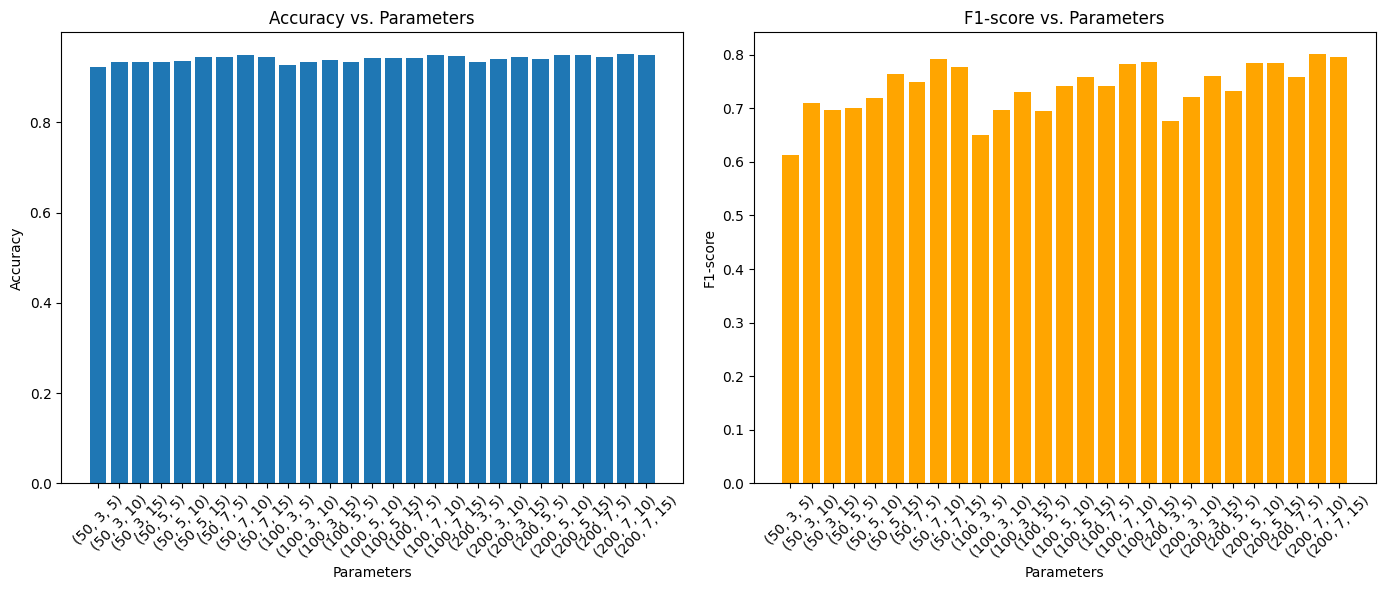

Mejores parámetros: (200, 7, 10)
Mejor precisión: 0.95
Mejor F1-score: 0.80


In [10]:
# Graficar los resultados
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))

# Gráfico de precisión
axes[0].set_title('Accuracy vs. Parameters')
axes[0].set_xlabel('Parameters')
axes[0].set_ylabel('Accuracy')
axes[0].bar(range(len(accuracy_results)), accuracy_results.values(), align='center')
axes[0].set_xticks(range(len(accuracy_results)))
axes[0].set_xticklabels(accuracy_results.keys(), rotation=45)

# Gráfico de F1-score
axes[1].set_title('F1-score vs. Parameters')
axes[1].set_xlabel('Parameters')
axes[1].set_ylabel('F1-score')
axes[1].bar(range(len(f1_results)), f1_results.values(), align='center', color='orange')
axes[1].set_xticks(range(len(f1_results)))
axes[1].set_xticklabels(f1_results.keys(), rotation=45)

plt.tight_layout()
plt.show()

# Utilizar el mejor modelo para predecir el objetivo binario
best_params = max(accuracy_results, key=accuracy_results.get)
best_accuracy, best_f1 = accuracy_results[best_params], f1_results[best_params]
print(f"Mejores parámetros: {best_params}")
print(f"Mejor precisión: {best_accuracy:.2f}")
print(f"Mejor F1-score: {best_f1:.2f}")